# AirNow and CAM-chem SE (unstructured grid)

Here we show a quick example of how to compare unstructured grid model output to surface observations. Note that the sample file provided here shouldn't be used for scientific analysis. For scientific applications, the community MUSICAv0 CONUS simulates are available at https://doi.org/10.5065/tgbj-yv18. 

First we need to import the driver.

In [1]:
import sys
sys.path.append('../../')

In [ ]:
from melodies_monet import driver

## Initiate the analysis class

Now lets create an instance of the {mod}`melodies_monet.driver` {class}`~melodies_monet.driver.analysis` class.
It consists of 4 main parts: model instances, observation instances, a paired instance of both.
This will allow us to move things around the plotting function for spatial and overlays and more complex plots.

In [3]:
an = driver.analysis()
an

analysis(
    control='control.yaml',
    control_dict=None,
    models={},
    obs={},
    paired={},
    start_time=None,
    end_time=None,
    download_maps=True,
    output_dir=None,
    debug=False,
)

## Control File

Read in the required yaml control file that sets up all the definitons of what we want to pair and plot.

In [4]:
an.control = 'control_camchem_se.yaml'
an.read_control()
an.control_dict

{'analysis': {'start_time': '2019-09-05-00:00:00',
  'end_time': '2019-09-06-00:00:00',
  'output_dir': './output/airnow_camchemse',
  'download_maps': False,
  'debug': True},
 'model': {'cam-chem-se': {'files': 'example:camchem:se',
   'mod_type': 'cesm_se',
   'scrip_file': 'example:camchem:se_scrip',
   'radius_of_influence': 18000,
   'mapping': {'airnow': {'O3_SRF': 'OZONE'}},
   'projection': 'None',
   'plot_kwargs': {'color': 'dodgerblue', 'marker': '+', 'linestyle': '-.'}}},
 'obs': {'airnow': {'use_airnow': True,
   'filename': 'example:airnow:2019-09',
   'obs_type': 'pt_sfc',
   'variables': {'PM2.5': {'unit_scale': 1,
     'unit_scale_method': '*',
     'nan_value': -1.0,
     'ylabel_plot': 'PM2.5 (ug/m3)',
     'ty_scale': 2.0,
     'vmin_plot': 0.0,
     'vmax_plot': 22.0,
     'vdiff_plot': 15.0,
     'nlevels_plot': 23},
    'OZONE': {'unit_scale': 1,
     'unit_scale_method': '*',
     'nan_value': -1.0,
     'ylabel_plot': 'Ozone (ppbv)',
     'vmin_plot': 15.0,
  

## Load the model data 

The driver will automatically loop through the "models" found in the model section of the control file and create model classes for each. Classes include the label, mapping information, and xarray object as well as the filenames.  Note it can open multiple files easily by including wildcards. Here we are only opening one CAM-chem file.

In [5]:
an.open_models()

cam-chem-se
{'files': 'example:camchem:se', 'mod_type': 'cesm_se', 'scrip_file': 'example:camchem:se_scrip', 'radius_of_influence': 18000, 'mapping': {'airnow': {'O3_SRF': 'OZONE'}}, 'projection': 'None', 'plot_kwargs': {'color': 'dodgerblue', 'marker': '+', 'linestyle': '-.'}}
example:camchem:se
**** Reading CESM SE model output...


In [6]:
an.models

{'cam-chem-se': model(
     model='cesm_se',
     radius_of_influence=18000,
     mod_kwargs={'var_list': ['O3_SRF', 'lat', 'lon'], 'scrip_file': '/glade/u/home/cdswk/.cache/pooch/8834f0b10a87870342f40e37c461b326-ne0CONUS_ne30x8_np4_SCRIP.nc'},
     file_str='example:camchem:se',
     label='cam-chem-se',
     obj=...,
     mapping={'airnow': {'O3_SRF': 'OZONE'}},
     label='cam-chem-se',
     ...
 )}

In [7]:
an.models['cam-chem-se'].obj

<xarray.Dataset>
Dimensions:  (time: 24, z: 1, ncol: 174098)
Coordinates:
  * z        (z) float64 992.6
  * time     (time) datetime64[ns] 2019-09-05 ... 2019-09-05T23:00:00
Dimensions without coordinates: ncol
Data variables:
    O3_SRF   (time, z, ncol) float32 dask.array<chunksize=(24, 1, 174098), meta=np.ndarray>
    lat      (ncol) float64 dask.array<chunksize=(174098,), meta=np.ndarray>
    lon      (ncol) float64 dask.array<chunksize=(174098,), meta=np.ndarray>
Attributes: (12/13)
    ne:                         0
    np:                         4
    Conventions:                CF-1.0
    comment:                    Sample file created for MUSICA tutorial by Du...
    source:                     CAM
    case:                       f.e22.FCcotagsNudged.ne0CONUSne30x8.cesm220.2...
    ...                         ...
    initial_file:               /glade/p/acom/MUSICA/restart/ne0CONUSne30x8/f...
    topography_file:            /glade/p/cesmdata/cseg/inputdata/atm/cam/topo...
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           hour_1
    mio_has_unstructured_grid:  True
    mio_scrip_file:             /glade/u/home/cdswk/.cache/pooch/8834f0b10a87...

In [8]:
# All the info in the model class can be called here.
print(an.models['cam-chem-se'].label)
print(an.models['cam-chem-se'].mapping)

cam-chem-se
{'airnow': {'O3_SRF': 'OZONE'}}


In [9]:
# All the info in the analysis class can also be called.
print(an.start_time)
print(an.end_time)
print(an.download_maps)

2019-09-05 00:00:00
2019-09-06 00:00:00
True


## Open Obs

Now for monet-analysis we will open preprocessed data in either netcdf icartt or some other format.  We will not be retrieving data like monetio does for some observations (ie aeronet, airnow, etc....).  Instead we will provide utitilies to do this so that users can add more data easily.

Like models we list all obs objects in the yaml file and it will loop through and create driver.observation instances that include the model type, file, objects (i.e. data object) and label  

In [10]:
an.control_dict['obs']

{'airnow': {'use_airnow': True,
  'filename': 'example:airnow:2019-09',
  'obs_type': 'pt_sfc',
  'variables': {'PM2.5': {'unit_scale': 1,
    'unit_scale_method': '*',
    'nan_value': -1.0,
    'ylabel_plot': 'PM2.5 (ug/m3)',
    'ty_scale': 2.0,
    'vmin_plot': 0.0,
    'vmax_plot': 22.0,
    'vdiff_plot': 15.0,
    'nlevels_plot': 23},
   'OZONE': {'unit_scale': 1,
    'unit_scale_method': '*',
    'nan_value': -1.0,
    'ylabel_plot': 'Ozone (ppbv)',
    'vmin_plot': 15.0,
    'vmax_plot': 55.0,
    'vdiff_plot': 20.0,
    'nlevels_plot': 21}}}}

In [11]:
an.open_obs()

In [12]:
# All the info in the observation class can also be called.
an.obs['airnow'].obj

<xarray.Dataset>
Dimensions:     (x: 3786, time: 2091, y: 1)
Coordinates:
  * x           (x) int64 0 1 2 3 4 5 6 7 ... 3779 3780 3781 3782 3783 3784 3785
  * time        (time) datetime64[ns] 2019-09-01 ... 2019-09-30T00:30:00
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    siteid      (y, x) object ...
Dimensions without coordinates: y
Data variables: (12/30)
    BARPR       (time, y, x) float64 ...
    BC          (time, y, x) float64 ...
    CO          (time, y, x) float64 ...
    NO          (time, y, x) float64 ...
    NO2         (time, y, x) float64 ...
    NO2Y        (time, y, x) float64 ...
    ...          ...
    cmsa_name   (y, x) float64 ...
    msa_code    (y, x) float64 ...
    msa_name    (y, x) object ...
    state_name  (y, x) object ...
    epa_region  (y, x) object ...
    time_local  (time, y, x) datetime64[ns] ...
Attributes:
    title:         
    format:        NetCDF-4
    date_created:  2021-06-07

## Pair model and obs data

In [13]:
%%time

an.pair_data()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
CPU times: user 20.3 s, sys: 9.42 s, total: 29.8 s
Wall time: 31.6 s


In [14]:
an.paired

{'airnow_cam-chem-se': pair(
     type='pt_sfc',
     radius_of_influence=1000000.0,
     obs='airnow',
     model='cam-chem-se',
     model_vars=['O3_SRF', 'lon', 'lat'],
     obs_vars=['OZONE'],
     filename='airnow_cam-chem-se.nc',
 )}

In [15]:
an.paired['airnow_cam-chem-se'].obj

<xarray.Dataset>
Dimensions:     (time: 2091, x: 3786)
Coordinates:
  * time        (time) datetime64[ns] 2019-09-01 ... 2019-09-30T00:30:00
  * x           (x) int64 0 1 2 3 4 5 6 7 ... 3779 3780 3781 3782 3783 3784 3785
Data variables: (12/34)
    BARPR       (time, x) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    BC          (time, x) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    CO          (time, x) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    NO          (time, x) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    NO2         (time, x) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    NO2Y        (time, x) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    ...          ...
    cmsa_name   (x) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    msa_code    (x) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 3.306e+04 -1.0 -1.0
    msa_name    (x) object '' '' '' '' '' '' '' ... '' '' '' ' Miami, OK ' '' ''
    state_name  (x) object 'CC' 'CC' 'CC' 'CC' 'CC' 'CC' ... '' '' '' '' '' ''
    epa_region  (x) object 'CA' 'CA' 'CA' 'CA' 'CA' ... '' 'R6' 'DSMG' 'DSUZ'
    siteid      (x) object '000010102' '000010401' ... 'UB1010001' 'UZB010001'

## Generate plots

Reference std: 16.490056173116347
Reference std: 7.784897217322165
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
CPU times: user 31.8 s, sys: 12.9 s, total: 44.8 s
Wall time: 47.6 s


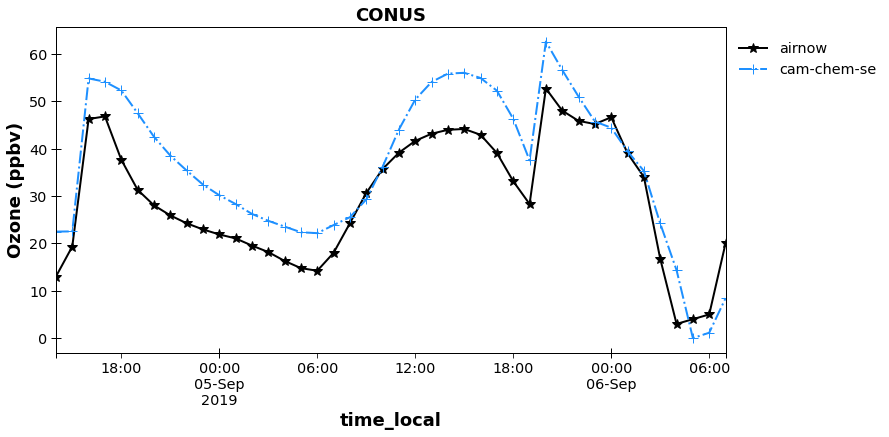

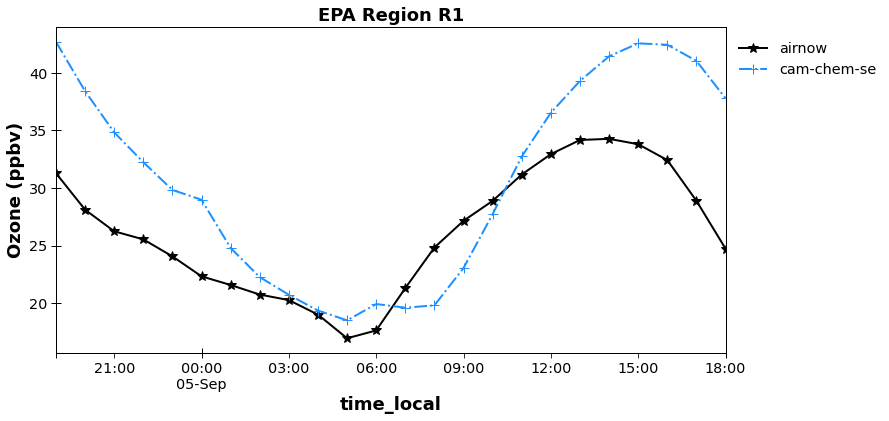

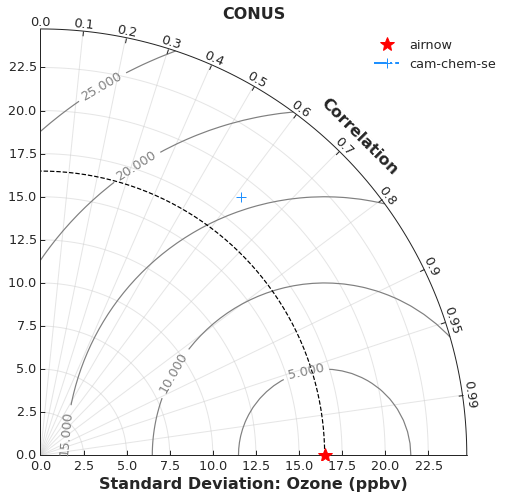

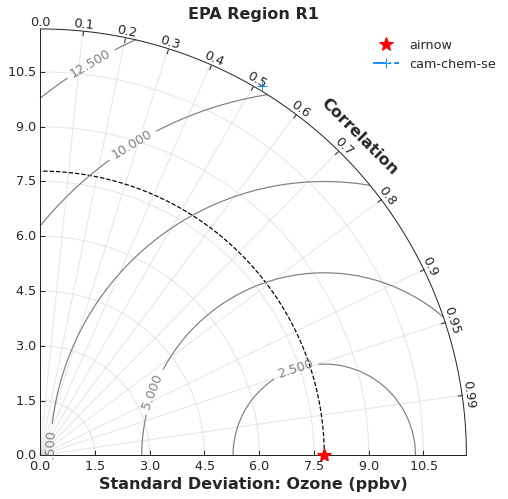

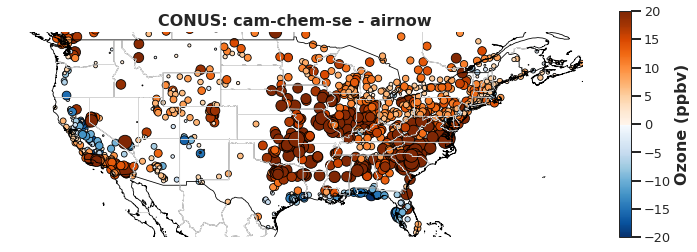

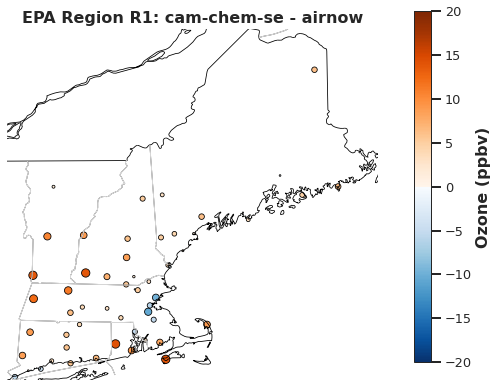

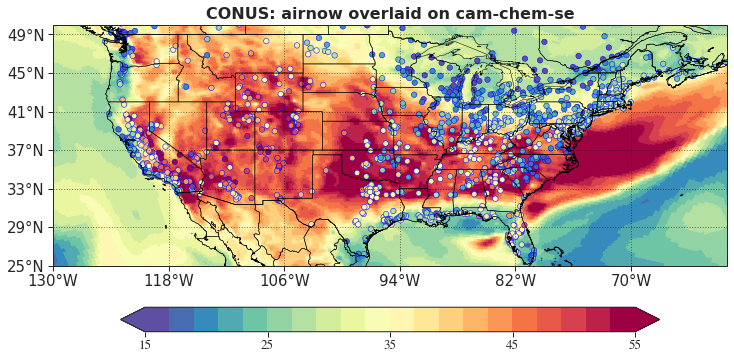

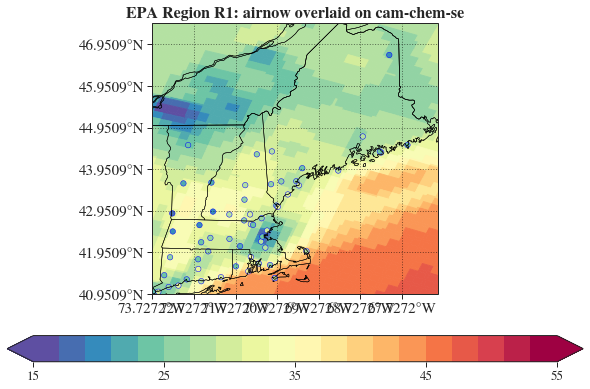

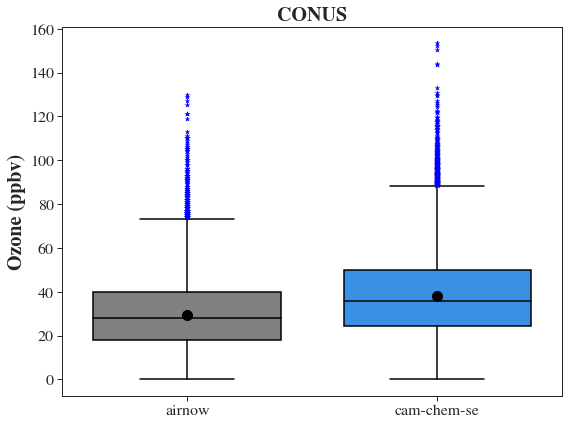

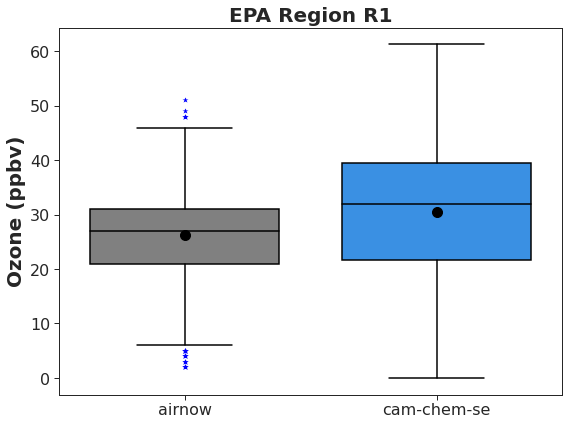

In [16]:
%%time

an.plotting()